In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, lax, vmap, jacobian
import jax.scipy.linalg as jsl

import jax

import numpy as np
from read_traj_v2 import *

import scipy.optimize

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# !pip3 install torch torchvision torchaudio

In [3]:
import torch
import torch.nn as nn

In [4]:
mol = 'heh+'
basis = 'sto-3g'
init = 'hf'
td = 'rt-tdexx'

dt = 0.08268/10

inpath = './correctdata'
inpath2 = './mydata/'
outpath = './'
saved_model_dir = './models/'

trnfrq = jnp.array(np.load('./tdcis_data/tdcis_trnfreq_dt0.008268.npz'))
trnamp = jnp.array(np.load('./tdcis_data/tdcis_trnamp_dt0.008268.npz'))
trntme = jnp.array(np.load('./tdcis_data/tdcis_trntme_dt0.008268.npz'))
# load important static matrices
a = traj_data(inpath, mol, basis, init, td, '001',
                init_cond_file=f'ke+en+overlap+ee_twoe+dip_casscf22_{mol}_{basis}.npz',
                )
a.assign_init_data()
drc = a.drc
xmat, didat, kinmat, enmat = a.xmat, a.didat, a.kinmat, a.enmat
X = xmat


	reading from "./correctdata/ke+en+overlap+ee_twoe+dip_casscf22_heh+_sto-3g.npz"

can only concatenate str (not "NoneType") to str
True is not in list


In [5]:
trnden = np.array(np.load('./tdcis_data/tdcis_dt0.0082680.npz'))
print(trnden.shape)

(301, 10000, 2, 2)


In [6]:
trntimecoeffs = np.array(np.load('./tdcis_data/time_coeffs_tdcis_dt0.008268.npz'))
print(trntimecoeffs.shape)

(300, 10000, 2)


In [7]:
torch.set_default_dtype(torch.float64)
input_size = 16
output_size = 4
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()                    
        # layer 1
        self.fc1 = nn.Linear(input_size, 256) 
        self.batch1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.25)

        # layer 2
        self.fc2 = nn.Linear(256, 256)
        self.batch2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.25)

        # layer 3
        self.fc3 = nn.Linear(256, 256)
        self.batch3 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.25)

        # layer 4
        self.fc4 = nn.Linear(256, 256)
        self.batch4 = nn.BatchNorm1d(256)
        self.drop4 = nn.Dropout(0.25)

        self.fc5 = nn.Linear(256, output_size)
        
        self.selu = nn.SELU() 
        self.sm = nn.Softmax(dim=1)
    def forward(self, x):                            

        # layer 1
        out = self.fc1(x)
        out = self.batch1(out)
        out = self.selu(out)
        #out = self.drop1(out)

        # layer 2
        out = self.fc2(out)
        out = self.batch2(out)
        out = self.selu(out)
        #out = self.drop2(out)

        # layer 3
        out = self.fc3(out)
        out = self.batch3(out)
        out = self.selu(out)
        #out = self.drop3(out)

        # layer 4
        out = self.fc4(out)
        out = self.batch4(out)
        out = self.selu(out)
        #out = self.drop4(out)

        out = self.fc5(out)
        out = self.sm(out)
        return out


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('using gpu')

using gpu


In [9]:
#TODO split into real and imaginary parts
X = trnden[140].reshape((10000,4))
y = trntimecoeffs[140]
X.shape, y.shape

((10000, 4), (10000, 2))

In [10]:
X

array([[0.10477089+0.00000000e+00j, 0.30625791+0.00000000e+00j,
        0.30625791+0.00000000e+00j, 0.89522938+0.00000000e+00j],
       [0.10477089+0.00000000e+00j, 0.30625791+0.00000000e+00j,
        0.30625791+0.00000000e+00j, 0.89522938+0.00000000e+00j],
       [0.10477089+6.78269230e-24j, 0.30625792-1.90978295e-06j,
        0.30625792+1.90978295e-06j, 0.89522937-1.05200500e-23j],
       ...,
       [0.11820466-2.04482806e-18j, 0.31036451-8.85466911e-02j,
        0.31036451+8.85466911e-02j, 0.88179556-2.15445319e-18j],
       [0.1186949 -1.17808971e-18j, 0.31099718-8.84392895e-02j,
        0.31099718+8.84392895e-02j, 0.88130531+1.26516016e-18j],
       [0.11918453+1.91714554e-18j, 0.31162905-8.83246533e-02j,
        0.31162905+8.83246533e-02j, 0.88081568-7.48351412e-18j]])

In [11]:
centered_X = X-np.mean(X)
sclfac = np.max(np.abs(centered_X))
print(sclfac)
#X = centered_X/sclfac
X = X - np.min(X)/(np.max(X)-np.min(X))

0.5435931668218476


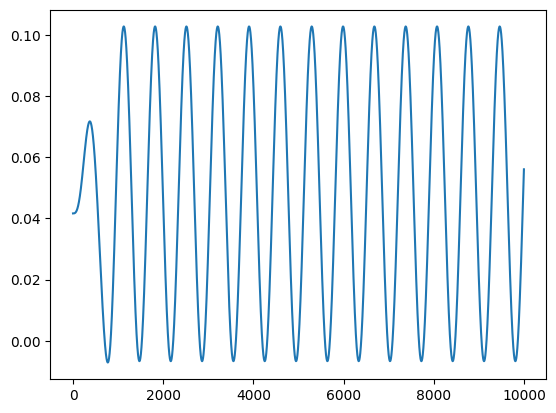

In [12]:
plt.plot(X[:,0].real)

In [13]:
newX = np.zeros((X.shape[0], 16))
for i in range(0,3):
    newX[i] = np.append(np.array([X[i][0].real, X[i][1].real, X[i][1].imag, X[i][3].real]), np.zeros(12))
for i in range(3, X.shape[0]):
    newX[i] = np.array([X[i][0].real, X[i][1].real, X[i][1].imag, X[i][3].real,
                       X[i-1][0].real, X[i-1][1].real, X[i-1][1].imag, X[i-1][3].real,
                       X[i-2][0].real, X[i-2][1].real, X[i-2][1].imag, X[i-2][3].real,
                       X[i-3][0].real, X[i-3][1].real, X[i-3][1].imag, X[i-3][3].real])

In [14]:
newy = np.zeros((y.shape[0],4))
for i in range(y.shape[0]):
    newy[i] = np.array([y[i][0].real, y[i][0].imag, y[i][1].real, y[i][1].imag])

In [15]:
X = newX
y = newy

In [16]:
# from sklearn.model_selection import train_test_split
# train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.10, random_state=57109, shuffle=True)

In [17]:
train_datat = torch.from_numpy(X)
train_labelst = torch.from_numpy(y)

In [18]:
net = Net(input_size, output_size)
net = net.to(device)

In [19]:
train_datat = train_datat.to(device)
train_labelst = train_labelst.to(device)

In [20]:
from torch.nn.functional import mse_loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [ ]:
num_epochs = 1000
batch_size = 10000
losses = []
for epoch in range(1, num_epochs + 1):
        final_loss = 0
        for i in range(0, train_datat.shape[0], batch_size):
            optimizer.zero_grad()
            if i + batch_size > train_datat.shape[0]:
                batched_data = train_datat[i:]
            else:
                batched_data = train_datat[i: i + batch_size]
            outputs = net(batched_data)
            loss =  mse_loss(outputs, train_labelst[i: i + batch_size])
            final_loss = loss
            loss.backward()
            optimizer.step()
        losses.append(loss) 
        if epoch % 100 == 0:
            print('Epoch: {}/{}.............'.format(epoch, num_epochs), end=' ')
            print("Loss: {:.4f}".format(loss.item()))

In [22]:
net(torch.from_numpy(newX).to(device))

tensor([[ 1.0000e+00, 9.0035e-147, 2.7151e-184, 1.2515e-150],
        [ 1.0000e+00, 9.0035e-147, 2.7151e-184, 1.2515e-150],
        [ 1.0000e+00, 9.0038e-147, 2.7152e-184, 1.2516e-150],
        ...,
        [ 1.0000e+00, 1.8287e-113, 1.8406e-109, 5.1958e-114],
        [ 1.0000e+00, 9.2318e-114, 6.7018e-110, 2.5786e-114],
        [ 1.0000e+00, 4.6473e-114, 2.4224e-110, 1.2734e-114]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [23]:
newy

array([[ 1.0000000e+00,  3.4200000e-06, -1.0000000e-08, -2.7000000e-06],
       [ 1.0000000e+00,  1.0270000e-05, -6.0000000e-08, -8.1000000e-06],
       [ 1.0000000e+00,  2.0530000e-05, -1.7000000e-07, -1.6200000e-05],
       ...,
       [ 9.9182448e-01,  8.7885200e-03, -1.7524880e-02, -1.2609455e-01],
       [ 9.9182448e-01,  8.7885200e-03, -1.8664610e-02, -1.2593089e-01],
       [ 9.9182448e-01,  8.7885200e-03, -1.9802810e-02, -1.2575693e-01]])

In [24]:
x = net(torch.from_numpy(newX).to(device)).cpu()
y = newy
np.linalg.norm((x.detach().numpy()-y))

12.665044271172238